<a href="https://colab.research.google.com/github/vmazashvili/EAI/blob/main/EAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-supervised Pretraining

In [ ]:
# prompt: connect different google drive account

from google.colab import drive
# Mount the first drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pillow opencv-python
!pip install tqdm
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np

# DATASETS

In [ ]:
# Mount Google Drive if not already mounted
drive.mount('/content/drive')

# Setup paths
UNLABELED_PATH = '/content/drive/MyDrive/data/filtered_good_mock/'
LABELED_BASE_PATH = '/content/drive/MyDrive/data/PatchDataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

def compute_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images in loader:
        # Flatten batch and calculate mean and std for each channel
        batch_samples = images.size(0)  # batch size (number of images)
        images = images.view(batch_samples, images.size(1), -1)  # Flatten H and W
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std

In [ ]:
import os
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from torchvision.io import read_image
from tqdm import tqdm

class NormalizationTransforms:
    @staticmethod
    def global_normalize(image_tensor):
        """Global min-max normalization"""
        min_val = torch.min(image_tensor)
        max_val = torch.max(image_tensor)
        return (image_tensor - min_val) / (max_val - min_val + 1e-8)

    @staticmethod
    def robust_normalize(image_tensor, low_percentile=0.5, high_percentile=99.5):
        """Robust normalization using percentiles with clipping"""
        # Calculate percentiles for each channel
        mins = torch.quantile(image_tensor.view(3, -1), low_percentile / 100.0, dim=1)
        maxs = torch.quantile(image_tensor.view(3, -1), high_percentile / 100.0, dim=1)

        # Normalize each channel and clip values
        normalized = torch.stack([
            (channel - min_val) / (max_val - min_val + 1e-8)
            for channel, min_val, max_val in zip(image_tensor, mins, maxs)
        ])
        return torch.clamp(normalized, 0.0, 1.0)

    @staticmethod
    def normalize(image_tensor, mean=None, std=None):
        """
        Perform standard normalization of an image tensor.

        Args:
            image_tensor (torch.Tensor): The image tensor of shape (C, H, W).
            mean (list or torch.Tensor, optional): Mean for each channel. If None, it's computed from the image.
            std (list or torch.Tensor, optional): Standard deviation for each channel. If None, it's computed from the image.

        Returns:
            torch.Tensor: Normalized image tensor.
        """
        if mean is None:
            mean = image_tensor.mean(dim=(-1, -2), keepdim=True)
        if std is None:
            std = image_tensor.std(dim=(-1, -2), keepdim=True) + 1e-8  # Avoid division by zero

        normalized = (image_tensor - mean) / std
        return normalized

    @staticmethod
    def filter_overexposed(image_tensor, threshold=0.4, max_white_ratio=0.3):
        """Check if the image is overexposed."""
        white_ratio = torch.mean((image_tensor > threshold).float())
        return white_ratio < max_white_ratio

    @staticmethod
    def filter_underexposed(image_tensor, threshold=0.35, max_dark_ratio=0.9):
        """Check if the image is underexposed."""
        dark_ratio = torch.mean((image_tensor < threshold).float())
        return dark_ratio < max_dark_ratio


class UnlabeledDataset(Dataset):
    def __init__(self, root_dir, normalization='none', filter_overexposed=False, filter_underexposed=False):
        self.root_dir = root_dir
        self.normalization = normalization
        self.filter_overexposed = filter_overexposed
        self.filter_underexposed = filter_underexposed
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

        # Filter the dataset if needed
        if filter_overexposed or filter_underexposed:
            self.image_files = self._prefilter_images()

    def __len__(self):
        return len(self.image_files)

    def _prefilter_images(self):
        filtered_files = []
        for img_file in tqdm(self.image_files, desc="Filtering images"):
            img_path = os.path.join(self.root_dir, img_file)
            image_tensor = read_image(img_path).float() / 255.0  # Read and normalize tensor
            is_valid = True
            if self.filter_overexposed:
                is_valid &= NormalizationTransforms.filter_overexposed(image_tensor)
            if self.filter_underexposed:
                is_valid &= NormalizationTransforms.filter_underexposed(image_tensor)

            if is_valid:
                filtered_files.append(img_file)
        return filtered_files

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image_tensor = read_image(img_path).float() / 255.0  # Load as tensor

        # Apply normalization
        if self.normalization == 'global':
            image_tensor = NormalizationTransforms.global_normalize(image_tensor)
        elif self.normalization == 'robust':
            image_tensor = NormalizationTransforms.robust_normalize(image_tensor)
        elif self.normalization == 'regular':
            image_tensor = NormalizationTransforms.normalize(image_tensor)

        return image_tensor


class LabeledDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, normalization='none'):
        self.root_dir = root_dir
        self.base_transform = transform
        self.normalization = normalization
        self.samples = []

        split_dir = os.path.join(root_dir, split)
        for label, class_name in enumerate(['negative', 'positive']):
            class_dir = os.path.join(split_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith('.png'):
                        self.samples.append((os.path.join(class_dir, img_name), label))

    def __len__(self):  # Added this method
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)

        if self.base_transform:
            image = self.base_transform(image)

        if self.normalization == 'global':
            image = NormalizationTransforms.global_normalize(image)
        elif self.normalization == 'robust':
            image = NormalizationTransforms.robust_normalize(image)

        return image, label


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import transforms
from tqdm import tqdm
import random
import os
from PIL import Image
from torch.utils.data import Dataset

def get_pixel_values_subset(dataset, num_samples=1000, is_labeled=False, desc="Processing"):
    """Extract pixel values from a random subset of images."""
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    subset = Subset(dataset, indices)
    subset_loader = DataLoader(subset, batch_size=128, shuffle=False)

    all_pixels = []
    for batch in tqdm(subset_loader, desc=desc):
        if is_labeled:
            images = batch[0]
        else:
            images = batch

        pixels = images.reshape(-1, images.size(1)).numpy()
        all_pixels.append(pixels)

    return np.concatenate(all_pixels, axis=0)

def plot_efficient_distribution(unlabeled_pixels, labeled_pixels, bins=50, title_suffix=""): #add title_suffix as an argument with default value ""
    """Plot histograms instead of KDE for faster visualization."""
    plt.figure(figsize=(15, 5))
    channels = ['Red', 'Green', 'Blue']

    for i in range(3):
        plt.subplot(1, 3, i+1)

        plt.hist(unlabeled_pixels[:, i], bins=bins, alpha=0.5,
                density=True, label='Unlabeled', color='blue')
        plt.hist(labeled_pixels[:, i], bins=bins, alpha=0.5,
                density=True, label='Labeled', color='orange')

        plt.title(f'{channels[i]} Channel Distribution {title_suffix}') # incorporate the title suffix
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.show()
def analyze_distributions_efficient(unlabeled_dataset, labeled_dataset, num_samples=1000):
    print("\nAnalyzing distributions...")

    unlabeled_pixels = get_pixel_values_subset(
        unlabeled_dataset,
        num_samples,
        is_labeled=False,
        desc="Processing unlabeled data"
    )

    labeled_pixels = get_pixel_values_subset(
        labeled_dataset,
        num_samples,
        is_labeled=True,
        desc="Processing labeled data"
    )

    print("\nPlotting distributions...")
    plot_efficient_distribution(unlabeled_pixels, labeled_pixels)

    unlabeled_mean = unlabeled_pixels.mean(axis=0)
    unlabeled_std = unlabeled_pixels.std(axis=0)
    labeled_mean = labeled_pixels.mean(axis=0)
    labeled_std = labeled_pixels.std(axis=0)

    return {
        'unlabeled': {'mean': unlabeled_mean, 'std': unlabeled_std},
        'labeled': {'mean': labeled_mean, 'std': labeled_std}
    }


In [ ]:
# Initial transform (always needed to convert to tensor)
initial_transform = transforms.Compose([
    transforms.ToTensor()
])

# # First, try with no normalization (original behavior):
# unlabeled_dataset = UnlabeledDataset(UNLABELED_PATH,
#                                     transform=initial_transform,
#                                     normalization='none')
# train_dataset = LabeledDataset(LABELED_BASE_PATH,
#                               split='train',
#                               transform=initial_transform,
#                               normalization='none')

# val_dataset = LabeledDataset(LABELED_BASE_PATH,
#                             split='val',
#                              transform=initial_transform,
#                              normalization='none')

# test_dataset = LabeledDataset(LABELED_BASE_PATH,
#                             split='test',
#                              transform=initial_transform,
#                              normalization='none')

# labeled_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

# OR, try global normalization:
# unlabeled_dataset = UnlabeledDataset(UNLABELED_PATH,
#                                     transform=initial_transform,
#                                     normalization='global')
# train_dataset = LabeledDataset(LABELED_BASE_PATH,
#                               split='train',
#                               transform=initial_transform,
#                               normalization='global')

# val_dataset = LabeledDataset(LABELED_BASE_PATH,
#                             split='val',
#                              transform=initial_transform,
#                              normalization='global')

# test_dataset = LabeledDataset(LABELED_BASE_PATH,
#                             split='test',
#                              transform=initial_transform,
#                              normalization='global')

# labeled_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

# # OR, try robust normalization:
# unlabeled_dataset = UnlabeledDataset(UNLABELED_PATH,
#                                     transform=initial_transform,
#                                     normalization='robust')
# train_dataset = LabeledDataset(LABELED_BASE_PATH,
#                               split='train',
#                               transform=initial_transform,
#                               normalization='robust')

# val_dataset = LabeledDataset(LABELED_BASE_PATH,
#                             split='val',
#                              transform=initial_transform,
#                              normalization='robust')

# test_dataset = LabeledDataset(LABELED_BASE_PATH,
#                             split='test',
#                              transform=initial_transform,
#                              normalization='robust')

# labeled_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

# OR, try filtering overexposed images + global normalization:
unlabeled_dataset = UnlabeledDataset(UNLABELED_PATH,
                                    #transform=initial_transform,
                                    normalization='none',
                                    filter_overexposed=False,
                                    filter_underexposed=False)
train_dataset = LabeledDataset(LABELED_BASE_PATH,
                              split='train',
                              transform=initial_transform,
                              normalization='none')

val_dataset = LabeledDataset(LABELED_BASE_PATH,
                            split='val',
                             transform=initial_transform,
                             normalization='none')

test_dataset = LabeledDataset(LABELED_BASE_PATH,
                            split='test',
                             transform=initial_transform,
                             normalization='none')

labeled_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

In [ ]:
import numpy as np
import torch
from sklearn.decomposition import IncrementalPCA # Import IncrementalPCA
from sklearn.neighbors import KernelDensity
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import os
import joblib
from collections import Counter
import matplotlib.pyplot as plt
import random
import gc

def get_pixel_values_subset_memory_efficient(dataset, num_samples=1000, is_labeled=False, desc="Processing", chunk_size=32):
    """Extract pixel values from a random subset of images in smaller chunks."""
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    subset = Subset(dataset, indices)
    subset_loader = DataLoader(subset, batch_size=chunk_size, shuffle=False)

    all_pixels = []
    for batch in tqdm(subset_loader, desc=desc):
        if is_labeled:
            images = batch[0]
        else:
            images = batch

        with torch.no_grad():  # Reduce memory usage during computation
            pixels = images.reshape(-1, images.size(1)).numpy()
            all_pixels.append(pixels)

        # Clear some memory
        del images, pixels
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return np.concatenate(all_pixels, axis=0)

def extract_and_save_pixels_in_chunks(dataset, output_filename, chunk_size=32, max_chunks=None):
    """Extract and save pixel values to disk in small chunks with memory cleanup."""
    dataloader = DataLoader(dataset, batch_size=chunk_size, shuffle=False)

    # Open a memory-mapped file for incremental saving
    sample_batch = next(iter(dataloader))
    if isinstance(sample_batch, (list, tuple)):
        sample_images = sample_batch[0]
    else:
        sample_images = sample_batch

    # Calculate shape for memory mapping
    total_samples = len(dataset)
    pixels_per_image = int(np.prod(sample_images.shape[1:]))

    # Create memory-mapped array
    pixels_mmap = np.memmap(
        f"{output_filename}.mmap",
        dtype=np.float32,
        mode='w+',
        shape=(total_samples, pixels_per_image)
    )

    current_idx = 0
    chunk_count = 0

    for batch in tqdm(dataloader, desc=f"Extracting pixels for {output_filename}"):
        if isinstance(batch, (list, tuple)):
            images = batch[0]
        else:
            images = batch

        with torch.no_grad():
            batch_pixels = images.view(images.size(0), -1).numpy()
            batch_size = batch_pixels.shape[0]
            pixels_mmap[current_idx:current_idx + batch_size] = batch_pixels
            current_idx += batch_size

        # Clear memory
        del images, batch_pixels
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

        chunk_count += 1
        if max_chunks and chunk_count >= max_chunks:
            break

    # Flush changes to disk
    pixels_mmap.flush()

    # Save final array
    final_array = np.memmap(
        f"{output_filename}.mmap",
        dtype=np.float32,
        mode='r',
        shape=(current_idx, pixels_per_image)
    )

    joblib.dump(final_array, output_filename)

    # Clean up memory map file
    del pixels_mmap, final_array
    gc.collect()
    os.remove(f"{output_filename}.mmap")

def resample_distribution(unlabeled_dataset, labeled_dataset, num_samples,
                        temp_dir='temp_distributions', batch_size=32,
                        pca_components=10, kde_samples=1000, vis_samples=500, kde_bandwidth=0.01):
    """Memory-efficient version of resample_distribution with additional outputs."""
    os.makedirs(temp_dir, exist_ok=True)

    print("\n1. Initial Dataset Information:")
    print(f"Original unlabeled dataset size: {len(unlabeled_dataset)}")
    print(f"Original labeled dataset size: {len(labeled_dataset)}")

    # Plot original distributions with reduced sample size
    print("\n2. Plotting original pixel intensity distributions...")
    unlabeled_vis = get_pixel_values_subset_memory_efficient(unlabeled_dataset, vis_samples, False, "Processing unlabeled data", chunk_size=batch_size)
    labeled_vis = get_pixel_values_subset_memory_efficient(labeled_dataset, vis_samples, True, "Processing labeled data", chunk_size=batch_size)

    plot_efficient_distribution(unlabeled_vis, labeled_vis, title_suffix="(Original)")
    plt.close()  # Explicitly close plot to free memory

    # Extract pixels in chunks
    labeled_pixels_file = os.path.join(temp_dir, 'labeled_pixels.joblib')
    unlabeled_pixels_file = os.path.join(temp_dir, 'unlabeled_pixels.joblib')

    if not os.path.exists(labeled_pixels_file):
        print("Extracting labeled pixels...")
        extract_and_save_pixels_in_chunks(labeled_dataset, labeled_pixels_file, chunk_size=batch_size)

    if not os.path.exists(unlabeled_pixels_file):
        print("Extracting unlabeled pixels...")
        extract_and_save_pixels_in_chunks(unlabeled_dataset, unlabeled_pixels_file, chunk_size=batch_size)

    # Load data in chunks for PCA
    print("\n3. Dimensionality Information:")
    original_dimensionality = joblib.load(labeled_pixels_file).shape[1]
    print(f"Original feature dimensionality: {original_dimensionality}")
    print(f"Reducing to {pca_components} components...")

    pca = IncrementalPCA(n_components=pca_components)  # Initialize IncrementalPCA

    # Fit PCA in chunks with progress bar
    print("Fitting PCA...")
    try:
        for chunk_start in tqdm(range(0, len(labeled_dataset), batch_size), desc="Fitting PCA"):
            chunk_end = min(chunk_start + batch_size, len(labeled_dataset))
            chunk_data = joblib.load(labeled_pixels_file)[chunk_start:chunk_end]
            if chunk_start == 0:
                pca.fit(chunk_data)
            else:
                pca.partial_fit(chunk_data)
            del chunk_data
            gc.collect()
        print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.3f}")
    except Exception as e:
        print(f"Error during PCA fitting: {e}")
        return None

    print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.3f}")

    # Transform data in chunks with progress bar
    labeled_pca = np.memmap(
        os.path.join(temp_dir, 'labeled_pca.mmap'),
        dtype=np.float32,
        mode='w+',
        shape=(len(labeled_dataset), pca_components)
    )

    unlabeled_pca = np.memmap(
        os.path.join(temp_dir, 'unlabeled_pca.mmap'),
        dtype=np.float32,
        mode='w+',
        shape=(len(unlabeled_dataset), pca_components)
    )

    print("Transforming labeled data with PCA...")
    try:
        for chunk_start in tqdm(range(0, len(labeled_dataset), batch_size), desc="Transforming Labeled Data"):
            chunk_end = min(chunk_start + batch_size, len(labeled_dataset))
            chunk_data = joblib.load(labeled_pixels_file)[chunk_start:chunk_end]
            labeled_pca[chunk_start:chunk_end] = pca.transform(chunk_data)
            del chunk_data
            gc.collect()
        print("Labeled data transformation completed.")
    except Exception as e:
        print(f"Error during labeled data transformation: {e}")
        return None

    print("Transforming unlabeled data with PCA...")
    try:
        for chunk_start in tqdm(range(0, len(unlabeled_dataset), batch_size), desc="Transforming Unlabeled Data"):
            chunk_end = min(chunk_start + batch_size, len(unlabeled_dataset))
            chunk_data = joblib.load(unlabeled_pixels_file)[chunk_start:chunk_end]
            unlabeled_pca[chunk_start:chunk_end] = pca.transform(chunk_data)
            del chunk_data
            gc.collect()
        print("Unlabeled data transformation completed.")
    except Exception as e:
        print(f"Error during unlabeled data transformation: {e}")
        return None

    # Process KDE with reduced sample size
    if kde_samples:
        print("\n4. Computing densities...")
        try:
            labeled_indices = np.random.choice(len(labeled_dataset), kde_samples, replace=False)
            unlabeled_indices = np.random.choice(len(unlabeled_dataset), kde_samples, replace=False)

            kde_labeled = KernelDensity(kernel='gaussian')
            kde_unlabeled = KernelDensity(kernel='gaussian')

            kde_labeled.fit(labeled_pca[labeled_indices])
            kde_unlabeled.fit(unlabeled_pca[unlabeled_indices])
            print("KDE fitting completed.")
        except Exception as e:
            print(f"Error during KDE fitting: {e}")
            return None

    # Compute weights in chunks
    print("\n5. Weight Statistics:")
    try:
        weights = np.zeros(len(unlabeled_dataset))
        for i in range(0, len(unlabeled_dataset), batch_size):
            chunk = unlabeled_pca[i:i + batch_size]
            labeled_density = np.exp(kde_labeled.score_samples(chunk))
            unlabeled_density = np.exp(kde_unlabeled.score_samples(chunk))
            weights[i:i + batch_size] = labeled_density / (unlabeled_density + 1e-8)
            del chunk, labeled_density, unlabeled_density
            gc.collect()

        weights /= weights.sum()
        print(f"Min weight: {np.min(weights):.6f}")
        print(f"Max weight: {np.max(weights):.6f}")
        print(f"Mean weight: {np.mean(weights):.6f}")
    except Exception as e:
        print(f"Error during weight computation: {e}")
        return None

    # Clean up memory maps
    del labeled_pca, unlabeled_pca
    os.remove(os.path.join(temp_dir, 'labeled_pca.mmap'))
    os.remove(os.path.join(temp_dir, 'unlabeled_pca.mmap'))

    # Resample indices
    print("\n6. Resampling dataset...")
    resampled_indices = np.random.choice(len(unlabeled_dataset),
                                       size=num_samples,
                                       p=weights)
    resampled_subset = Subset(unlabeled_dataset, resampled_indices)

    # Plot resampled distributions
    print("\n7. Plotting resampled pixel intensity distributions...")
    resampled_vis = get_pixel_values_subset_memory_efficient(resampled_subset, vis_samples, False, "Processing resampled data", chunk_size=batch_size)
    plot_efficient_distribution(resampled_vis, labeled_vis, title_suffix="(Resampled)")
    plt.close()  # Explicitly close plot to free memory

    # Final dataset information
    print("\n8. Final Dataset Information:")
    print(f"Resampled dataset size: {len(resampled_subset)}")

    # TODO: let it return resampled indices too
    return resampled_subset, resampled_indices

In [ ]:
import optuna
from functools import partial
import numpy as np
import torch
from torch.utils.data import Subset
import warnings
import psutil
import os
warnings.filterwarnings('ignore', category=RuntimeWarning)

def get_memory_usage():
    """Get current memory usage in GB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024 / 1024  # Convert to GB

def check_memory(threshold_gb=0.8 * psutil.virtual_memory().total / 1024**3):
    """Check if memory usage is below threshold, returns True if safe"""
    current_gb = get_memory_usage()
    return current_gb < threshold_gb

def compute_kl_divergence(p, q, bins=50):
    """Compute KL divergence between two sets of samples."""
    # Compute histograms
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)

    # Add small constant to avoid division by zero
    p_hist = p_hist + 1e-10
    q_hist = q_hist + 1e-10

    # Normalize
    p_hist = p_hist / p_hist.sum()
    q_hist = q_hist / q_hist.sum()

    # Compute KL divergence
    return np.sum(p_hist * np.log(p_hist / q_hist))

def compute_js_divergence(p, q, bins=50):
    """Compute Jensen-Shannon divergence between two sets of samples."""
    # Compute histograms
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)

    # Add small constant to avoid division by zero
    p_hist = p_hist + 1e-10
    q_hist = q_hist + 1e-10

    # Normalize
    p_hist = p_hist / p_hist.sum()
    q_hist = q_hist / q_hist.sum()

    # Compute midpoint distribution
    m_hist = 0.5 * (p_hist + q_hist)

    # Compute JS divergence
    return 0.5 * (np.sum(p_hist * np.log(p_hist / m_hist)) +
                 np.sum(q_hist * np.log(q_hist / m_hist)))

def get_initial_pca_dims(labeled_dataset, batch_size):
    """Get the initial dimensionality from a single image."""
    first_batch = next(iter(torch.utils.data.DataLoader(
        Subset(labeled_dataset, [0]),  # Only look at first image
        batch_size=1,
        shuffle=False
    )))
    if isinstance(first_batch, (list, tuple)):
        images = first_batch[0]
    else:
        images = first_batch
    return int(np.prod(images.shape[1:]))

def objective(trial, unlabeled_dataset, labeled_dataset, base_num_samples,
              temp_dir='temp_distributions', eval_samples=500):  # Reduced eval samples
    """
    Memory-efficient objective function for optimization.
    """
    # Check memory before starting
    if not check_memory():
        print("Warning: High memory usage detected. Skipping trial.")
        return float('inf')

    # Use smaller batch sizes
    batch_size = trial.suggest_categorical('batch_size', [8, 16])

    # Get initial dimensionality from a single image
    try:
        initial_dims = get_initial_pca_dims(labeled_dataset, batch_size)
    except Exception as e:
        print(f"Error getting initial dimensions: {e}")
        return float('inf')

    # More conservative parameter ranges
    max_pca = min(30, initial_dims, trial.suggest_int('max_pca', 5, 30))
    params = {
        'pca_components': trial.suggest_int('pca_components', 5, max_pca),
        'kde_samples': trial.suggest_int('kde_samples', 200, 1000),  # Reduced range
        'kde_bandwidth': trial.suggest_float('kde_bandwidth', 0.001, 0.1, log=True),
        'batch_size': batch_size
    }

    print(f"\nTrial parameters:")
    for key, value in params.items():
        print(f"{key}: {value}")
    print(f"Current memory usage: {get_memory_usage():.2f} GB")

    try:
        # Run resampling with memory checks
        resampled_subset, indices = resample_distribution(
            unlabeled_dataset=unlabeled_dataset,
            labeled_dataset=labeled_dataset,
            num_samples=min(base_num_samples, 1000),  # Limit sample size
            temp_dir=temp_dir,
            **params
        )

        if not check_memory():
            print("Warning: High memory usage after resampling. Aborting trial.")
            return float('inf')

        if resampled_subset is None:
            return float('inf')

        # Use smaller evaluation samples
        eval_size = min(eval_samples, 500)
        labeled_eval = get_pixel_values_subset_memory_efficient(
            labeled_dataset,
            eval_size,
            is_labeled=True,
            desc="Evaluating labeled data",
            chunk_size=params['batch_size']
        )

        resampled_eval = get_pixel_values_subset_memory_efficient(
            resampled_subset,
            eval_size,
            is_labeled=False,
            desc="Evaluating resampled data",
            chunk_size=params['batch_size']
        )

        # Calculate metrics
        kl_div = compute_kl_divergence(labeled_eval, resampled_eval)
        js_div = compute_js_divergence(labeled_eval, resampled_eval)
        score = kl_div + js_div

        print(f"Trial score: {score:.6f}")
        print(f"KL divergence: {kl_div:.6f}")
        print(f"JS divergence: {js_div:.6f}")
        print(f"Final memory usage: {get_memory_usage():.2f} GB")

        return score

    except Exception as e:
        print(f"Error in trial: {str(e)}")
        return float('inf')

def optimize_resampling(unlabeled_dataset, labeled_dataset, base_num_samples,
                       n_trials=20, temp_dir='temp_distributions'):  # Reduced trials
    """
    Memory-efficient optimization with early stopping.
    """
    def memory_callback(study, trial):
        if not check_memory():
            study.stop()

    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )

    objective_func = partial(
        objective,
        unlabeled_dataset=unlabeled_dataset,
        labeled_dataset=labeled_dataset,
        base_num_samples=base_num_samples,
        temp_dir=temp_dir
    )

    # Run optimization with memory monitoring
    print(f"Starting optimization with {n_trials} trials")
    print(f"Initial memory usage: {get_memory_usage():.2f} GB")

    try:
        study.optimize(objective_func, n_trials=n_trials, callbacks=[memory_callback])
    except Exception as e:
        print(f"Optimization stopped: {e}")

    print("\nOptimization Results:")
    if study.best_trial.value == float('inf'):
        print("No successful trials - using conservative default parameters")
        best_params = {
            'pca_components': 5,
            'kde_samples': 200,
            'kde_bandwidth': 0.01,
            'batch_size': 8
        }
    else:
        print(f"Best trial value: {study.best_trial.value}")
        best_params = study.best_trial.params

    print("Best parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")

    # Final resampling with best parameters
    best_resampled_subset, best_indices = resample_distribution(
        unlabeled_dataset=unlabeled_dataset,
        labeled_dataset=labeled_dataset,
        num_samples=min(base_num_samples, 1000),  # Limit final sample size
        temp_dir=temp_dir,
        **best_params
    )

    return best_resampled_subset, best_indices, best_params

In [ ]:
# resampled_subset = resample_distribution(
#     unlabeled_dataset,
#     labeled_dataset,
#     num_samples=3000,
#     batch_size=128,          # Keep this since it works
#     pca_components=50,      # Reduced from 50 but still captures key features
#     kde_samples=5000,       # Middle ground between your 1000 and 5000 tests
#     kde_bandwidth=0.7,     # Slightly reduced to check feature definition
#     vis_samples=500         # This is fine for visualization
# )

Save and load resampled indices rather than resampled dataset because it is way more efficient and we can get the resampled dataset from it without further processing

In [ ]:
# temp_dir = 'temp_distributions'  # Define temp_dir
# os.makedirs(temp_dir, exist_ok=True)  # Create the directory if it doesn't exist

# resampled_subset_file = os.path.join(temp_dir, 'resampled_subset.joblib')
# joblib.dump(resampled_subset, resampled_subset_file)
# print(f"Resampled subset saved to {resampled_subset_file}")


In [ ]:
# prompt: create /temp_distributions directory
# look for resampled_subset.joblib in /content/drive/MyDrive/data
# copy it in temp_distributions folder

import os
import shutil

# Create the temporary directory
!mkdir /content/temp_distributions

# Source and destination paths
source_path = '/content/drive/MyDrive/data/resampled_subset.joblib'
destination_path = '/content/temp_distributions'

# Check if the source file exists
if os.path.exists(source_path):
    # Copy the file
    shutil.copy2(source_path, destination_path)
    print(f"File '{source_path}' copied to '{destination_path}' successfully.")
else:
    print(f"Source file '{source_path}' not found.")


File '/content/drive/MyDrive/data/resampled_subset.joblib' copied to '/content/temp_distributions' successfully.


In [ ]:
# Load the resampled subset
temp_dir = 'temp_distributions'  # Define temp_dir
resampled_subset_file = os.path.join(temp_dir, 'resampled_subset.joblib')
resampled_subset = joblib.load(resampled_subset_file)
print(f"Resampled subset loaded from {resampled_subset_file}")


Resampled subset loaded from temp_distributions/resampled_subset.joblib


In [ ]:
from torch.utils.data import Dataset
import torch
import joblib
from torch.utils.data import Subset

class ResampledDataset(Dataset):
    """Custom Dataset for loading unlabeled resampled data from joblib file"""
    def __init__(self, joblib_path, transform=None, dummy_label=-1):
        """
        Args:
            joblib_path (str): Path to the .joblib file containing resampled data
            transform (callable, optional): Optional transform to be applied to samples
            dummy_label (int, optional): Label to use for unlabeled data, defaults to -1
        """
        loaded_data = joblib.load(joblib_path)

        # If tuple, take just the subset, otherwise use the data directly
        self.subset = loaded_data[0] if isinstance(loaded_data, tuple) else loaded_data

        self.transform = transform
        self.dummy_label = dummy_label

        # Print debug info
        print(f"Dataset size: {len(self.subset)}")

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        # Get the sample from the subset
        sample = self.subset[idx]

        # If the subset returns a tuple (data, label), take only the data
        if isinstance(sample, tuple):
            sample = sample[0]

        # Apply transform if provided
        if self.transform:
            sample = self.transform(sample)

        return sample, self.dummy_label

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

def validate_dataset(dataset, batch_size=4, expected_shape=None):
    """
    Comprehensive dataset validation utility.

    Args:
        dataset: PyTorch Dataset object to validate
        batch_size: Batch size to test with
        expected_shape: Expected shape of individual samples (optional)

    Returns:
        dict: Validation results and statistics
    """
    results = {
        'is_valid': True,
        'errors': [],
        'warnings': [],
        'stats': {}
    }

    # Basic dataset checks
    try:
        length = len(dataset)
        results['stats']['dataset_size'] = length
        if length == 0:
            results['is_valid'] = False
            results['errors'].append("Dataset is empty")
            return results
    except Exception as e:
        results['is_valid'] = False
        results['errors'].append(f"Dataset length check failed: {str(e)}")
        return results

    # Sample access check
    try:
        first_item = dataset[0]
        if not isinstance(first_item, (tuple, torch.Tensor)):
            results['warnings'].append(f"Unexpected item type: {type(first_item)}")
    except Exception as e:
        results['is_valid'] = False
        results['errors'].append(f"Cannot access first item: {str(e)}")
        return results

    # Data type and shape consistency check
    shapes = []
    types = []
    try:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        for batch_idx, batch in enumerate(dataloader):
            if batch_idx >= 3:  # Check first 3 batches
                break

            if isinstance(batch, (list, tuple)):
                batch_data = batch[0]
            else:
                batch_data = batch

            if isinstance(batch_data, list):
                results['warnings'].append("Batch returned as list - may need custom collate_fn")
                continue

            shapes.append(batch_data.shape)
            types.append(batch_data.dtype)

            # Basic tensor checks
            if torch.isnan(batch_data).any():
                results['warnings'].append(f"NaN values detected in batch {batch_idx}")
            if torch.isinf(batch_data).any():
                results['warnings'].append(f"Infinite values detected in batch {batch_idx}")

    except Exception as e:
        results['is_valid'] = False
        results['errors'].append(f"Batch iteration failed: {str(e)}")
        return results

    # Shape consistency
    if len(set(str(s) for s in shapes)) > 1:
        results['is_valid'] = False
        results['errors'].append(f"Inconsistent shapes across batches: {shapes}")
    else:
        results['stats']['batch_shape'] = shapes[0] if shapes else None

    # Type consistency
    if len(set(types)) > 1:
        results['warnings'].append(f"Mixed datatypes across batches: {types}")
    else:
        results['stats']['data_type'] = types[0] if types else None

    # Shape validation
    if expected_shape and shapes:
        if shapes[0][1:] != expected_shape:
            results['warnings'].append(
                f"Unexpected shape: got {shapes[0][1:]}, expected {expected_shape}")

    return results

def print_validation_results(results):
    """Pretty print the validation results"""
    print("\n=== Dataset Validation Results ===")
    print(f"Valid: {results['is_valid']}")

    if results['errors']:
        print("\nErrors:")
        for error in results['errors']:
            print(f"❌ {error}")

    if results['warnings']:
        print("\nWarnings:")
        for warning in results['warnings']:
            print(f"⚠️ {warning}")

    if results['stats']:
        print("\nStats:")
        for key, value in results['stats'].items():
            print(f"📊 {key}: {value}")

In [ ]:
class ResampledDataset(Dataset):
    def __init__(self, joblib_path, transform=None, dummy_label=-1):
        loaded_data = joblib.load(joblib_path)
        self.subset = loaded_data[0] if isinstance(loaded_data, tuple) else loaded_data
        self.transform = transform
        self.dummy_label = dummy_label

    def __getitem__(self, idx):
        sample = self.subset[idx]
        # Ensure sample is a tensor
        if not isinstance(sample, torch.Tensor):
            sample = torch.tensor(sample, dtype=torch.float32)
        if self.transform:
            sample = self.transform(sample)
        return sample, self.dummy_label

    def __len__(self):
        return len(self.subset)

# Create your dataset
resampled_dataset = ResampledDataset(resampled_subset_file)

# Validate it
validation_results = validate_dataset(
    test_dataset,
    batch_size=64,
    expected_shape=None  # Add your expected shape here, e.g. (3, 224, 224)
)

# Print results
print_validation_results(validation_results)


=== Dataset Validation Results ===
Valid: True

Stats:
📊 dataset_size: 867
📊 batch_shape: torch.Size([64, 3, 200, 200])
📊 data_type: torch.float32


### analyzing datasets

### Create Dataloaders

In [ ]:
from torch.utils.data import DataLoader

# Create data loaders
batch_size = 32  # Adjust as needed
unlabeled_loader = DataLoader(resampled_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=2)  # Remove collate_fn
train_loader = DataLoader(train_dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=2)
val_loader = DataLoader(val_dataset,
                       batch_size=batch_size,
                       shuffle=False,
                       num_workers=2)
test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=2)

# ARCHITECTURE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class CustomResNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Modified initial conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.InstanceNorm2d(64)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

        # Load ResNet-18 layers
        resnet = models.resnet18(pretrained=False)
        self.layer1 = resnet.layer1  # 64 -> 64
        self.layer2 = resnet.layer2  # 64 -> 128
        self.layer3 = resnet.layer3  # 128 -> 256
        self.layer4 = resnet.layer4  # 256 -> 512

    def forward(self, x):
        x = self.conv1(x)      # 200x200
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)     # 200x200
        x = self.layer2(x)     # 100x100
        x = self.layer3(x)     # 50x50
        x = self.layer4(x)     # 25x25
        return x

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm1 = nn.InstanceNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm2 = nn.InstanceNorm2d(channels)
        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        residual = x
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        x += residual
        return self.relu(x)

class MaskedAutoencoder(nn.Module):
    def __init__(self, mask_ratio=0.75):
        super().__init__()
        self.mask_ratio = mask_ratio
        self.encoder = CustomResNetEncoder()

        # Adjusted decoder for ResNet-18 (512 channels input)
        decoder_layers = []

        # First block: 512 -> 256
        decoder_layers.extend([
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ResidualBlock(256)
        ])

        # Second block: 256 -> 128
        decoder_layers.extend([
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ResidualBlock(128)
        ])

        # Third block: 128 -> 64
        decoder_layers.extend([
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ResidualBlock(64)
        ])

        # Final layers
        decoder_layers.extend([
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.InstanceNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(16, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        ])

        self.decoder = nn.Sequential(*decoder_layers)

    def random_masking(self, x):
        B, C, H, W = x.shape
        patch_size = 20  # For 200x200 images, using 20x20 patches
        num_patches = (H // patch_size) * (W // patch_size)
        num_masked = int(self.mask_ratio * num_patches)

        noise = torch.rand(B, num_patches, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        mask = torch.ones(B, num_patches, dtype=torch.bool, device=x.device)
        mask[:, :num_masked] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)

        mask = mask.reshape(B, H // patch_size, W // patch_size)
        mask = mask.unsqueeze(1).repeat(1, C, patch_size, patch_size)
        mask = mask.reshape(B, C, H, W)

        masked_x = x * mask
        return masked_x, mask

    def forward(self, x):
        masked_x, mask = self.random_masking(x)
        encoded = self.encoder(masked_x)
        reconstructed = self.decoder(encoded)
        return reconstructed, mask

class DetailEnhancedLoss(nn.Module):
    def __init__(self, alpha=0.8, beta=0.2):
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def edge_loss(self, pred, target):
        def get_edge(x):
            dx = x[:, :, :, 1:] - x[:, :, :, :-1]
            dy = x[:, :, 1:, :] - x[:, :, :-1, :]
            return dx, dy

        pred_dx, pred_dy = get_edge(pred)
        target_dx, target_dy = get_edge(target)

        edge_loss = F.l1_loss(pred_dx, target_dx) + F.l1_loss(pred_dy, target_dy)
        return edge_loss

    def forward(self, pred, target, mask):
        recon_loss = F.l1_loss(pred * (~mask).float(), target * (~mask).float())
        edge_loss = self.edge_loss(pred * (~mask).float(), target * (~mask).float())
        return self.alpha * recon_loss + self.beta * edge_loss

import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from pathlib import Path

def save_reconstructions(model, val_loader, epoch, device, save_dir='reconstructions'):
    """Save reconstruction examples."""
    Path(save_dir).mkdir(exist_ok=True)

    model.eval()
    with torch.no_grad():
        # Get a batch of images
        images, _ = next(iter(val_loader))
        images = images.to(device)

        # Get reconstructions
        reconstructed_images, mask = model(images)

        # Create a grid of original and reconstructed images
        num_images = min(8, images.size(0))  # Display up to 8 images
        comparison = torch.cat([
            images[:num_images],
            reconstructed_images[:num_images],
            images[:num_images] * (~mask[:num_images]).float()  # Masked input
        ])

        # Save the grid
        vutils.save_image(
            comparison,
            f'{save_dir}/reconstruction_epoch_{epoch}.png',
            nrow=num_images,
            normalize=True
        )

def plot_losses(train_losses, val_losses, save_dir='plots'):
    """Plot and save training and validation losses."""
    Path(save_dir).mkdir(exist_ok=True)

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{save_dir}/loss_plot.png')
    plt.close()

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    device = next(model.parameters()).device
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    patience = 5

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Lists to store losses for plotting
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, _ = batch
            images = images.to(device)

            optimizer.zero_grad()
            reconstructed_images, mask = model(images)
            loss = criterion(reconstructed_images, images, mask)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                images, _ = batch
                images = images.to(device)
                reconstructed_images, mask = model(images)
                loss = criterion(reconstructed_images, images, mask)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Val Loss: {val_loss:.4f}")

        # Save losses for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Save reconstructions and plot losses every 5 epochs
        if (epoch + 1) % 5 == 0:
            save_reconstructions(model, val_loader, epoch + 1, device)
            plot_losses(train_losses, val_losses)

        scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'best_val_loss': best_val_loss
            }, "/content/drive/MyDrive/data/best_masked_autoencoder.pth")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # Final plots
    plot_losses(train_losses, val_losses)
    save_reconstructions(model, val_loader, epoch + 1, device)

    return train_losses, val_losses

# Create directories for saving results
Path('reconstructions').mkdir(exist_ok=True)
Path('plots').mkdir(exist_ok=True)

# Initialize and train
model = MaskedAutoencoder(mask_ratio=0.75).to(device)
criterion = DetailEnhancedLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Train and get loss histories
train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/100: 100%|██████████| 197/197 [45:18<00:00, 13.80s/it]

Epoch 1/100, Train Loss: 0.0894


Epoch 1/100, Val Loss: 0.0733


Epoch 2/100: 100%|██████████| 197/197 [05:06<00:00,  1.55s/it]

Epoch 2/100, Train Loss: 0.0652


Epoch 2/100, Val Loss: 0.0623


Epoch 3/100: 100%|██████████| 197/197 [05:06<00:00,  1.55s/it]

Epoch 3/100, Train Loss: 0.0550


Epoch 3/100, Val Loss: 0.0519


Epoch 4/100: 100%|██████████| 197/197 [05:06<00:00,  1.55s/it]

Epoch 4/100, Train Loss: 0.0495


Epoch 4/100, Val Loss: 0.0475


Epoch 5/100: 100%|██████████| 197/197 [05:05<00:00,  1.55s/it]

Epoch 5/100, Train Loss: 0.0456


Epoch 5/100, Val Loss: 0.0421


Epoch 6/100: 100%|██████████| 197/197 [05:05<00:00,  1.55s/it]

Epoch 6/100, Train Loss: 0.0422


Epoch 6/100, Val Loss: 0.0413


Epoch 7/100: 100%|██████████| 197/197 [05:05<00:00,  1.55s/it]

Epoch 7/100, Train Loss: 0.0407


Epoch 7/100, Val Loss: 0.0373


Epoch 8/100: 100%|██████████| 197/197 [05:03<00:00,  1.54s/it]

Epoch 8/100, Train Loss: 0.0387


Epoch 8/100, Val Loss: 0.0411


Epoch 9/100: 100%|██████████| 197/197 [05:01<00:00,  1.53s/it]

Epoch 9/100, Train Loss: 0.0367


Epoch 9/100, Val Loss: 0.0388


Epoch 10/100: 100%|██████████| 197/197 [05:03<00:00,  1.54s/it]

Epoch 10/100, Train Loss: 0.0358


Epoch 10/100, Val Loss: 0.0345


Epoch 11/100: 100%|██████████| 197/197 [05:01<00:00,  1.53s/it]

Epoch 11/100, Train Loss: 0.0350


Epoch 11/100, Val Loss: 0.0321


Epoch 12/100: 100%|██████████| 197/197 [05:01<00:00,  1.53s/it]

Epoch 12/100, Train Loss: 0.0338


Epoch 12/100, Val Loss: 0.0354


Epoch 13/100: 100%|██████████| 197/197 [05:04<00:00,  1.54s/it]

Epoch 13/100, Train Loss: 0.0332


Epoch 13/100, Val Loss: 0.0306


Epoch 14/100: 100%|██████████| 197/197 [05:03<00:00,  1.54s/it]

Epoch 14/100, Train Loss: 0.0321


Epoch 14/100, Val Loss: 0.0353


Epoch 15/100: 100%|██████████| 197/197 [05:02<00:00,  1.54s/it]

Epoch 15/100, Train Loss: 0.0315


Epoch 15/100, Val Loss: 0.0296


Epoch 16/100: 100%|██████████| 197/197 [05:05<00:00,  1.55s/it]

Epoch 16/100, Train Loss: 0.0314


Epoch 16/100, Val Loss: 0.0286


Epoch 17/100: 100%|██████████| 197/197 [05:02<00:00,  1.54s/it]

Epoch 17/100, Train Loss: 0.0303


Epoch 17/100, Val Loss: 0.0304


Epoch 18/100: 100%|██████████| 197/197 [05:01<00:00,  1.53s/it]

Epoch 18/100, Train Loss: 0.0296


Epoch 18/100, Val Loss: 0.0288


Epoch 19/100: 100%|██████████| 197/197 [05:05<00:00,  1.55s/it]

Epoch 19/100, Train Loss: 0.0289


Epoch 19/100, Val Loss: 0.0277


Epoch 20/100: 100%|██████████| 197/197 [05:04<00:00,  1.54s/it]

Epoch 20/100, Train Loss: 0.0286


Epoch 20/100, Val Loss: 0.0285


Epoch 21/100: 100%|██████████| 197/197 [05:03<00:00,  1.54s/it]

Epoch 21/100, Train Loss: 0.0287


Epoch 21/100, Val Loss: 0.0279


Epoch 22/100: 100%|██████████| 197/197 [05:05<00:00,  1.55s/it]

Epoch 22/100, Train Loss: 0.0280


Epoch 22/100, Val Loss: 0.0266


Epoch 23/100: 100%|██████████| 197/197 [05:02<00:00,  1.53s/it]

Epoch 23/100, Train Loss: 0.0279


Epoch 23/100, Val Loss: 0.0287


Epoch 24/100: 100%|██████████| 197/197 [05:01<00:00,  1.53s/it]

Epoch 24/100, Train Loss: 0.0274


Epoch 24/100, Val Loss: 0.0258


Epoch 25/100: 100%|██████████| 197/197 [05:04<00:00,  1.55s/it]

Epoch 25/100, Train Loss: 0.0269


Epoch 25/100, Val Loss: 0.0264


Epoch 26/100: 100%|██████████| 197/197 [05:02<00:00,  1.54s/it]

Epoch 26/100, Train Loss: 0.0263


Epoch 26/100, Val Loss: 0.0260


Epoch 27/100: 100%|██████████| 197/197 [05:01<00:00,  1.53s/it]

Epoch 27/100, Train Loss: 0.0265


Epoch 27/100, Val Loss: 0.0255


Epoch 28/100: 100%|██████████| 197/197 [05:04<00:00,  1.55s/it]

Epoch 28/100, Train Loss: 0.0258


Epoch 28/100, Val Loss: 0.0253


Epoch 29/100: 100%|██████████| 197/197 [05:03<00:00,  1.54s/it]

Epoch 29/100, Train Loss: 0.0259


Epoch 29/100, Val Loss: 0.0273


Epoch 30/100: 100%|██████████| 197/197 [05:03<00:00,  1.54s/it]

Epoch 30/100, Train Loss: 0.0255


Epoch 30/100, Val Loss: 0.0241


Epoch 31/100: 100%|██████████| 197/197 [05:04<00:00,  1.55s/it]

Epoch 31/100, Train Loss: 0.0254


Epoch 31/100, Val Loss: 0.0304


Epoch 32/100: 100%|██████████| 197/197 [05:03<00:00,  1.54s/it]

Epoch 32/100, Train Loss: 0.0248


Epoch 32/100, Val Loss: 0.0254


Epoch 33/100: 100%|██████████| 197/197 [05:02<00:00,  1.53s/it]

Epoch 33/100, Train Loss: 0.0249


Epoch 33/100, Val Loss: 0.0248


Epoch 34/100: 100%|██████████| 197/197 [05:04<00:00,  1.55s/it]

Epoch 34/100, Train Loss: 0.0245


Epoch 34/100, Val Loss: 0.0242


Epoch 35/100: 100%|██████████| 197/197 [05:03<00:00,  1.54s/it]

Epoch 35/100, Train Loss: 0.0240


Epoch 35/100, Val Loss: 0.0245
Early stopping at epoch 35


In [ ]:
import torch
from pathlib import Path

def load_checkpoint(model, checkpoint_path, device=None, eval_mode=True):
    """
    Load a checkpoint into the model.

    Args:
        model: The MaskedAutoencoder model instance
        checkpoint_path: Path to the checkpoint file
        device: torch.device to load the model to (if None, uses current device)
        eval_mode: Whether to set the model to evaluation mode after loading

    Returns:
        model: Loaded model
        checkpoint_data: Dictionary containing training history and metadata
    """
    if device is None:
        device = next(model.parameters()).device

    # Check if checkpoint exists
    checkpoint_path = Path(checkpoint_path)
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    try:
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Load model state
        model.load_state_dict(checkpoint['model_state_dict'])

        # Move model to device
        model = model.to(device)

        # Set to eval mode if requested
        if eval_mode:
            model.eval()

        # Extract training history and metadata
        checkpoint_data = {
            'epoch': checkpoint['epoch'],
            'train_losses': checkpoint.get('train_losses', []),
            'val_losses': checkpoint.get('val_losses', []),
            'best_val_loss': checkpoint.get('best_val_loss', float('inf'))
        }

        print(f"Successfully loaded checkpoint from epoch {checkpoint_data['epoch']}")
        print(f"Best validation loss: {checkpoint_data['best_val_loss']:.4f}")

        return model, checkpoint_data

    except Exception as e:
        print(f"Error loading checkpoint: {str(e)}")
        raise

# Example usage:
def main():
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MaskedAutoencoder(mask_ratio=0.75)

    # Load checkpoint
    try:
        model, checkpoint_data = load_checkpoint(
            model=model,
            checkpoint_path="/content/drive/MyDrive/data/best_masked_autoencoder_old.pth",
            device=device
        )

        # Print training history if needed
        if checkpoint_data['train_losses']:
            print(f"Number of training epochs: {len(checkpoint_data['train_losses'])}")
            print(f"Final training loss: {checkpoint_data['train_losses'][-1]:.4f}")
            print(f"Final validation loss: {checkpoint_data['val_losses'][-1]:.4f}")

    except Exception as e:
        print(f"Failed to load checkpoint: {str(e)}")
        return

    # Model is now ready for inference
    model.eval()
    with torch.no_grad():
        # Your inference code here
        pass

if __name__ == "__main__":
    main()

<ipython-input-21-cddd53932485>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Successfully loaded checkpoint from epoch 33
Best validation loss: 0.0251
Number of training epochs: 33
Final training loss: 0.0256
Final validation loss: 0.0251


# TRAINING

## Self-Supervised Pre-training

## Supervised Finetuning

### LOAD PRETRAINED MODEL

### MODIFY THE ARCHITECTURE TO CLASSIFIER

In [ ]:
class MedicalClassifier(nn.Module):
    def __init__(self, pretrained_model=None):
        super().__init__()
        self.encoder = pretrained_model.encoder

        # Freeze more layers
        for name, param in self.encoder.named_parameters():
            if any(x in name for x in ['layer1', 'layer2', 'layer3']):
                param.requires_grad = False

        # Simpler classifier with stronger regularization
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.BatchNorm1d(512),  # Add BatchNorm
            nn.Dropout(0.5),      # Increase dropout
            nn.Linear(512, 128),  # Reduce complexity
            nn.ReLU(),
            nn.BatchNorm1d(128),  # Add BatchNorm
            nn.Dropout(0.5),      # Increase dropout
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encode the input
        encoded = self.encoder(x)

        # Classify
        logits = self.classifier(encoded)
        return logits

### HYPERPARAMETERS

### FINETUNING

In [ ]:
!pip install scikit-learn  # Install scikit-learn if not already installed

In [ ]:
from sklearn.metrics import roc_auc_score  # Import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib


class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = 0

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif self.mode == 'max':
            if score <= self.best_score + self.min_delta:
                self.counter += 1
            else:
                self.best_score = score
                self.counter = 0
        else:  # mode == 'min'
            if score >= self.best_score - self.min_delta:
                self.counter += 1
            else:
                self.best_score = score
                self.counter = 0

        if self.counter >= self.patience:
            self.early_stop = True

        return self.early_stop

def train_classifier(model, train_loader, val_loader, device, num_epochs=200):
    print("Starting fine-tuning for binary classification...")

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW([
        {'params': model.encoder.parameters(), 'lr': 5e-6},
        {'params': model.classifier.parameters(), 'lr': 5e-5}
    ], weight_decay=0.1)

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='max',
                                 factor=0.2, patience=5,
                                 min_lr=1e-7)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=10, min_delta=0.001, mode='max')

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    best_val_auc = 0.0
    train_losses = []
    val_losses = []
    val_aucs = []

    # Lists to store learning rates
    encoder_lrs = []
    classifier_lrs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            predicted = (outputs.squeeze() > 0.5).float()
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)

        # Store current learning rates
        encoder_lrs.append(optimizer.param_groups[0]['lr'])
        classifier_lrs.append(optimizer.param_groups[1]['lr'])

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_labels = []
        val_preds = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images = images.to(device)
                labels = labels.float().to(device)

                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()

                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(outputs.squeeze().cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Compute validation metrics
        val_auc = roc_auc_score(val_labels, val_preds)  # Use imported roc_auc_score
        val_aucs.append(val_auc)

        # Update learning rate scheduler based on validation AUC
        scheduler.step(val_auc)

        # Save the best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_auc': val_auc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'val_aucs': val_aucs,
                'encoder_lrs': encoder_lrs,
                'classifier_lrs': classifier_lrs
            }, 'best_classification_model.pth')
            print(f"New best model saved with validation AUC: {val_auc:.4f}")

        # Print metrics
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {avg_val_loss:.4f}, Val AUC: {val_auc:.4f}")
        print(f"Learning rates - Encoder: {encoder_lrs[-1]:.2e}, Classifier: {classifier_lrs[-1]:.2e}")
        print("-" * 50)

        # Early stopping check
        if early_stopping(val_auc):
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

        # Clear memory at the end of each epoch
        torch.cuda.empty_cache()

    # Plot training and validation losses
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    plt.legend()
    plt.grid()

    # Plot validation AUC
    plt.subplot(1, 3, 2)
    plt.plot(val_aucs, label="Val AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.title("Validation AUC")
    plt.legend()
    plt.grid()

    # Plot learning rates
    plt.subplot(1, 3, 3)
    plt.plot(encoder_lrs, label="Encoder LR")
    plt.plot(classifier_lrs, label="Classifier LR")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.legend()
    plt.grid()
    plt.yscale('log')

    plt.tight_layout()
    plt.savefig("training_metrics.png")
    plt.show()

    return model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-21-cddd53932485>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Successfully loaded checkpoint from epoch 33
Best validation loss: 0.0251
Starting fine-tuning for binary classification...


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]


New best model saved with validation AUC: 0.6619

Epoch 1/200
Train Loss: 0.6668, Train Accuracy: 61.67%
Val Loss: 0.6641, Val AUC: 0.6619
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]


New best model saved with validation AUC: 0.7084

Epoch 2/200
Train Loss: 0.6075, Train Accuracy: 67.13%
Val Loss: 0.6366, Val AUC: 0.7084
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s]



Epoch 3/200
Train Loss: 0.5936, Train Accuracy: 68.55%
Val Loss: 0.6519, Val AUC: 0.6993
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]


New best model saved with validation AUC: 0.7344

Epoch 4/200
Train Loss: 0.5656, Train Accuracy: 71.14%
Val Loss: 0.6219, Val AUC: 0.7344
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]


New best model saved with validation AUC: 0.7463

Epoch 5/200
Train Loss: 0.5504, Train Accuracy: 72.61%
Val Loss: 0.6221, Val AUC: 0.7463
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


New best model saved with validation AUC: 0.7711

Epoch 6/200
Train Loss: 0.5417, Train Accuracy: 72.64%
Val Loss: 0.5847, Val AUC: 0.7711
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


New best model saved with validation AUC: 0.7805

Epoch 7/200
Train Loss: 0.5317, Train Accuracy: 73.63%
Val Loss: 0.5784, Val AUC: 0.7805
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]


New best model saved with validation AUC: 0.7903

Epoch 8/200
Train Loss: 0.5124, Train Accuracy: 75.22%
Val Loss: 0.5669, Val AUC: 0.7903
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]



Epoch 9/200
Train Loss: 0.5037, Train Accuracy: 75.60%
Val Loss: 0.6093, Val AUC: 0.7901
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]



Epoch 10/200
Train Loss: 0.4936, Train Accuracy: 75.89%
Val Loss: 0.6576, Val AUC: 0.7810
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]



Epoch 11/200
Train Loss: 0.4904, Train Accuracy: 76.31%
Val Loss: 0.6218, Val AUC: 0.7884
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


New best model saved with validation AUC: 0.7933

Epoch 12/200
Train Loss: 0.4807, Train Accuracy: 77.92%
Val Loss: 0.5873, Val AUC: 0.7933
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]


New best model saved with validation AUC: 0.8124

Epoch 13/200
Train Loss: 0.4714, Train Accuracy: 77.44%
Val Loss: 0.5623, Val AUC: 0.8124
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]



Epoch 14/200
Train Loss: 0.4648, Train Accuracy: 78.40%
Val Loss: 0.5797, Val AUC: 0.8059
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]



Epoch 15/200
Train Loss: 0.4580, Train Accuracy: 78.27%
Val Loss: 0.6090, Val AUC: 0.7896
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]



Epoch 16/200
Train Loss: 0.4540, Train Accuracy: 78.57%
Val Loss: 0.5680, Val AUC: 0.8102
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s]


New best model saved with validation AUC: 0.8275

Epoch 17/200
Train Loss: 0.4463, Train Accuracy: 79.59%
Val Loss: 0.5518, Val AUC: 0.8275
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]



Epoch 18/200
Train Loss: 0.4370, Train Accuracy: 79.52%
Val Loss: 0.6845, Val AUC: 0.8084
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]



Epoch 19/200
Train Loss: 0.4267, Train Accuracy: 80.13%
Val Loss: 0.6025, Val AUC: 0.8193
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]



Epoch 20/200
Train Loss: 0.4244, Train Accuracy: 80.73%
Val Loss: 0.6001, Val AUC: 0.8076
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]



Epoch 21/200
Train Loss: 0.4105, Train Accuracy: 81.41%
Val Loss: 0.5950, Val AUC: 0.8138
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]


New best model saved with validation AUC: 0.8290

Epoch 22/200
Train Loss: 0.4083, Train Accuracy: 82.13%
Val Loss: 0.5560, Val AUC: 0.8290
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]


New best model saved with validation AUC: 0.8335

Epoch 23/200
Train Loss: 0.3998, Train Accuracy: 81.89%
Val Loss: 0.5686, Val AUC: 0.8335
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]



Epoch 24/200
Train Loss: 0.3898, Train Accuracy: 82.75%
Val Loss: 0.6520, Val AUC: 0.8251
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]



Epoch 25/200
Train Loss: 0.3883, Train Accuracy: 83.30%
Val Loss: 0.6093, Val AUC: 0.8079
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s]



Epoch 26/200
Train Loss: 0.3765, Train Accuracy: 83.57%
Val Loss: 0.6271, Val AUC: 0.8220
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s]



Epoch 27/200
Train Loss: 0.3708, Train Accuracy: 83.84%
Val Loss: 0.5835, Val AUC: 0.8222
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]



Epoch 28/200
Train Loss: 0.3602, Train Accuracy: 84.26%
Val Loss: 0.5849, Val AUC: 0.8308
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]



Epoch 29/200
Train Loss: 0.3543, Train Accuracy: 84.59%
Val Loss: 0.5724, Val AUC: 0.8296
Learning rates - Encoder: 5.00e-06, Classifier: 5.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]



Epoch 30/200
Train Loss: 0.3454, Train Accuracy: 85.42%
Val Loss: 0.6105, Val AUC: 0.8274
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]



Epoch 31/200
Train Loss: 0.3316, Train Accuracy: 86.32%
Val Loss: 0.5996, Val AUC: 0.8320
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]



Epoch 32/200
Train Loss: 0.3364, Train Accuracy: 86.21%
Val Loss: 0.6354, Val AUC: 0.8325
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]


New best model saved with validation AUC: 0.8341

Epoch 33/200
Train Loss: 0.3290, Train Accuracy: 85.83%
Val Loss: 0.5859, Val AUC: 0.8341
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------
Early stopping triggered after 33 epochs


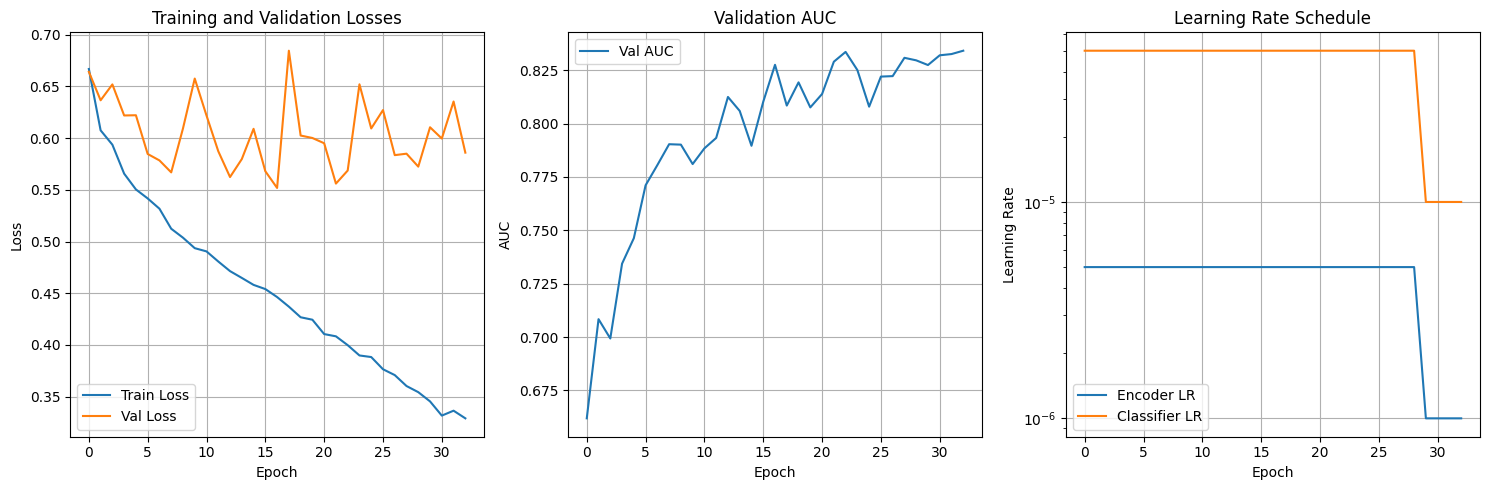

MedicalClassifier(
  (encoder): CustomResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU

In [ ]:
# Load the pretrained MaskedAutoencoder model
pretrained_model = MaskedAutoencoder(mask_ratio=0.75).to(device)
checkpoint_path = "/content/drive/MyDrive/data/best_masked_autoencoder_old.pth"
pretrained_model, _ = load_checkpoint(pretrained_model, checkpoint_path, device)

# Initialize the classification model
classification_model = MedicalClassifier(pretrained_model=pretrained_model).to(device)

# Create data loaders
#I could do 32 or possibly 64
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

# Fine-tune the model
train_classifier(classification_model, train_loader, val_loader, device, num_epochs=200)

# TESTING

<ipython-input-28-7c269114754e>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_classification_model.pth', map_location=device)


Starting evaluation...


Testing: 100%|██████████| 14/14 [03:07<00:00, 13.42s/it]



Test Results:
--------------------------------------------------
Loss        : 0.390
Accuracy    : 0.821 (95% CI: 0.796-0.847)
Sensitivity : 0.743 (95% CI: 0.714-0.772)
Specificity : 0.888 (95% CI: 0.867-0.909)
Precision   : 0.851 (95% CI: 0.828-0.875)
NPV         : 0.801 (95% CI: 0.774-0.827)
F1-Score    : 0.794 (95% CI: 0.767-0.821)
AUC         : 0.911 (95% CI: 0.892-0.930)


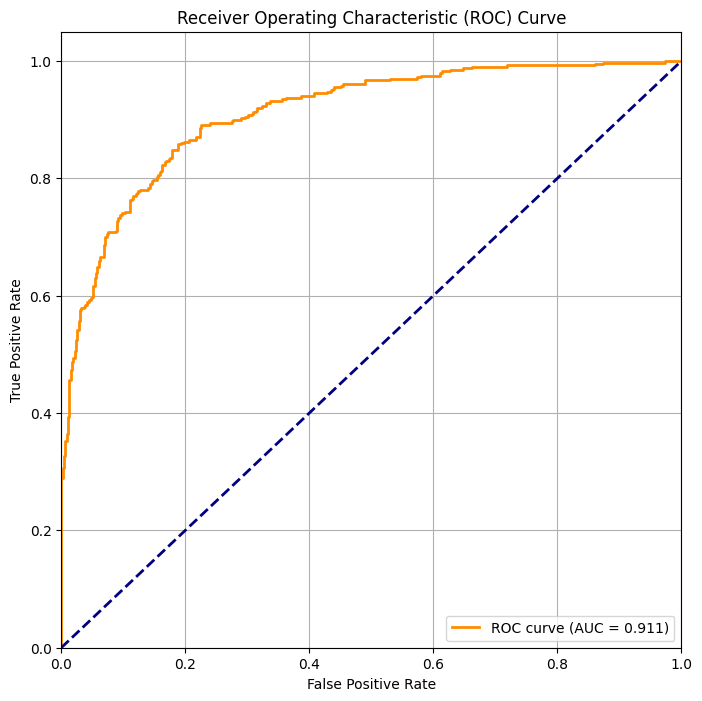

In [ ]:
import sklearn.metrics
from IPython import get_ipython
from IPython.display import display

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0
    criterion = nn.BCELoss()

    print("Starting evaluation...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            labels = labels.float().to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()

            # Store predictions and labels
            predictions = outputs.squeeze().cpu().numpy()
            labels = labels.cpu().numpy()
            all_preds.extend(predictions)
            all_labels.extend(labels)

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    average_loss = test_loss / len(test_loader)
    binary_preds = (all_preds > 0.5).astype(int)

    # True positives, false positives, etc.
    tp = np.sum((binary_preds == 1) & (all_labels == 1))
    fp = np.sum((binary_preds == 1) & (all_labels == 0))
    tn = np.sum((binary_preds == 0) & (all_labels == 0))
    fn = np.sum((binary_preds == 0) & (all_labels == 1))

    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    auc = roc_auc_score(all_labels, all_preds)

    # Calculate confidence intervals (95%)
    n = len(all_labels)
    z = 1.96  # 95% confidence interval

    def confidence_interval(p):
        std_err = np.sqrt((p * (1-p)) / n)
        return z * std_err

    metrics = {
        'Loss': f"{average_loss:.3f}",
        'Accuracy': f"{accuracy:.3f} (95% CI: {accuracy-confidence_interval(accuracy):.3f}-{accuracy+confidence_interval(accuracy):.3f})",
        'Sensitivity': f"{sensitivity:.3f} (95% CI: {sensitivity-confidence_interval(sensitivity):.3f}-{sensitivity+confidence_interval(sensitivity):.3f})",
        'Specificity': f"{specificity:.3f} (95% CI: {specificity-confidence_interval(specificity):.3f}-{specificity+confidence_interval(specificity):.3f})",
        'Precision': f"{precision:.3f} (95% CI: {precision-confidence_interval(precision):.3f}-{precision+confidence_interval(precision):.3f})",
        'NPV': f"{npv:.3f} (95% CI: {npv-confidence_interval(npv):.3f}-{npv+confidence_interval(npv):.3f})",
        'F1-Score': f"{f1:.3f} (95% CI: {f1-confidence_interval(f1):.3f}-{f1+confidence_interval(f1):.3f})",
        'AUC': f"{auc:.3f} (95% CI: {auc-confidence_interval(auc):.3f}-{auc+confidence_interval(auc):.3f})"
    }

    # Print results in a formatted way
    print("\nTest Results:")
    print("-" * 50)
    for metric, value in metrics.items():
        print(f"{metric:12s}: {value}")

    # Plot ROC curve
    fpr, tpr, _ = sklearn.metrics.roc_curve(all_labels, all_preds)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('roc_curve.png')
    plt.show()

    return metrics

# Usage
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Load best model
best_model = MedicalClassifier(pretrained_model=pretrained_model).to(device)
checkpoint = torch.load('best_classification_model.pth', map_location=device)
best_model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate
metrics = evaluate_model(best_model, test_loader, device)